# Medical Cost Prediction Project

### column overview: 

Predict medical costs for over 1300 individuals, based on attributes such as age, gender, BMI, how many children they have, if they are a smoker or not, and which region in the US they live.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import AdaBoostRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [2]:
%pwd

'/Users/nielsenreaveley/Desktop/medical costs'

In [3]:
df = pd.read_csv("/Users/nielsenreaveley/Desktop/medical costs/medical_costs.csv")
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [4]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [5]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

# Exploring data column by column

### Feature: Charges (our y column)

<Axes: xlabel='charges', ylabel='Count'>

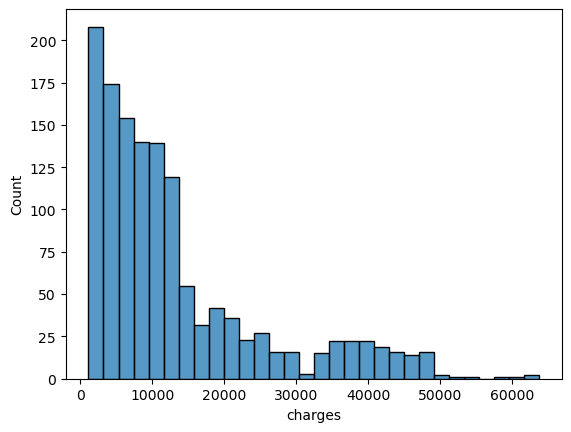

In [6]:
sns.histplot(df.charges) # could us hisplot also, basically the same

below we created another histogram, but this time with `bins` to see the distribution in terms of percentage

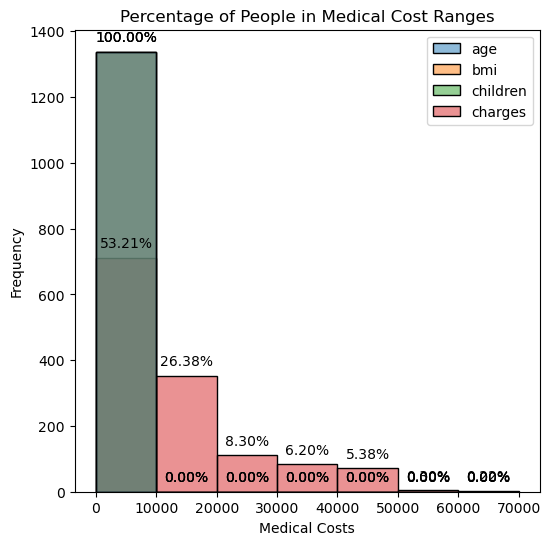

In [82]:
plt.figure(figsize=(6, 6))
ax = sns.histplot(df, bins=[0, 10000, 20000, 30000, 40000, 50000, 60000, 70000])

# Calculate and annotate the percentage on each bar
total_samples = len(df)
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_samples) * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Add labels
plt.title('Percentage of People in Medical Cost Ranges')
plt.xlabel('Medical Costs')
plt.ylabel('Frequency')

plt.show()

# Feature: Sex

<Axes: xlabel='count', ylabel='sex'>

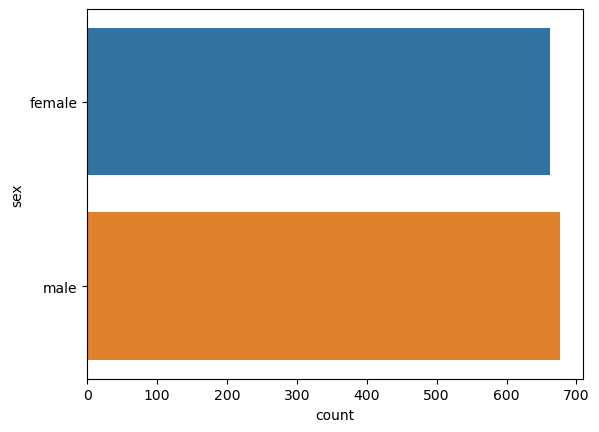

In [8]:
sns.countplot(y="sex", data=df)

In [9]:
df["sex"].value_counts() # very even split, slightly more men

male      676
female    662
Name: sex, dtype: int64

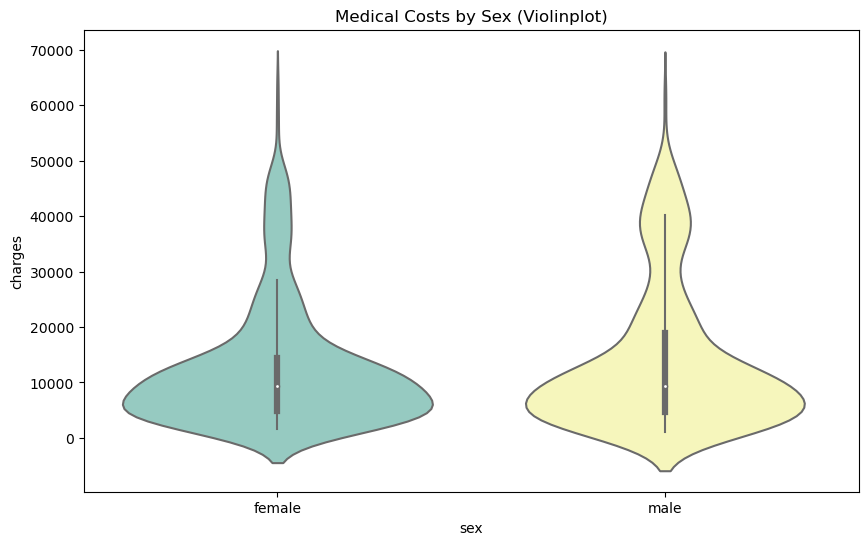

In [10]:
# Violin plot below shows guys and girls spend similar amounts
plt.figure(figsize=(10, 6))
sns.violinplot(x='sex', y='charges', data=df, palette="Set3")
plt.title('Medical Costs by Sex (Violinplot)')
plt.show()

# Feature: BMI

<Axes: xlabel='bmi', ylabel='Count'>

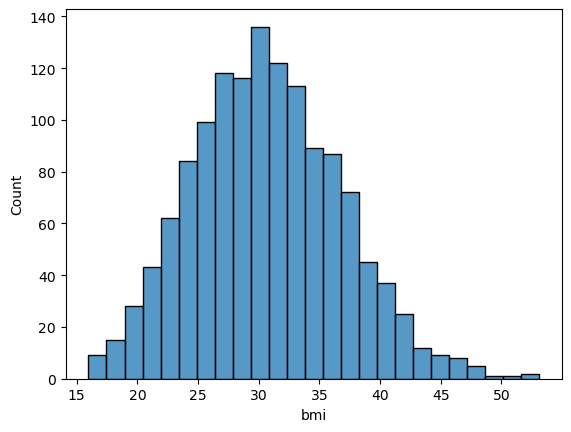

In [11]:
sns.histplot(df.bmi) # shows most people have BMI between 20 to 40

The regression scatterplot indicates people with BMI over 25 incur bigger medical costs by a noticeable amount. From research I've done on Google, this is interesting because people with BMI over 25 are considering overweight and obese, which aligns with what you would expect from a dataset like this...people who are overweight have substantially more medical costs!

<Axes: xlabel='bmi', ylabel='charges'>

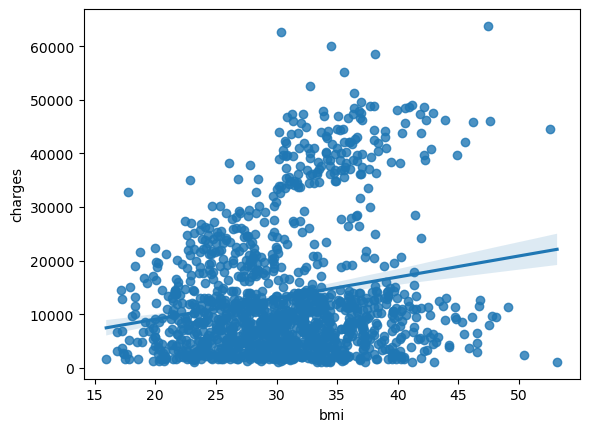

In [12]:
sns.regplot(x='bmi', y='charges', data=df)

# Feature: Children

<Axes: xlabel='count', ylabel='children'>

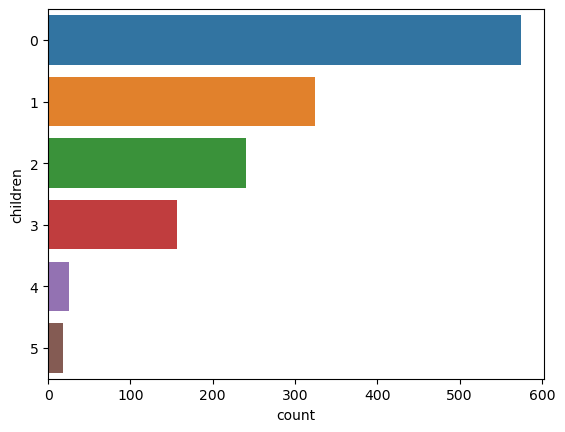

In [13]:
sns.countplot(y="children", data=df)

<Axes: xlabel='children', ylabel='charges'>

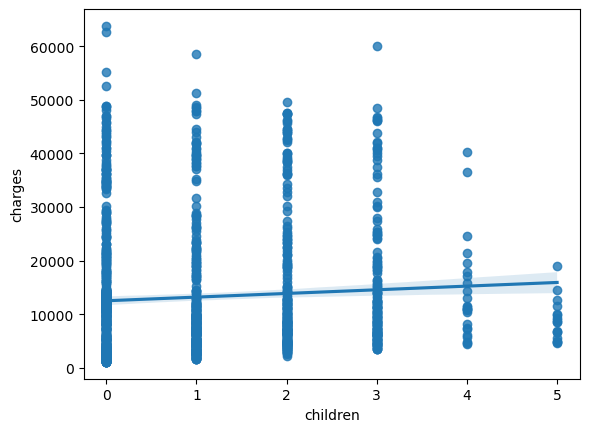

In [14]:
sns.regplot(x='children', y='charges', data=df)

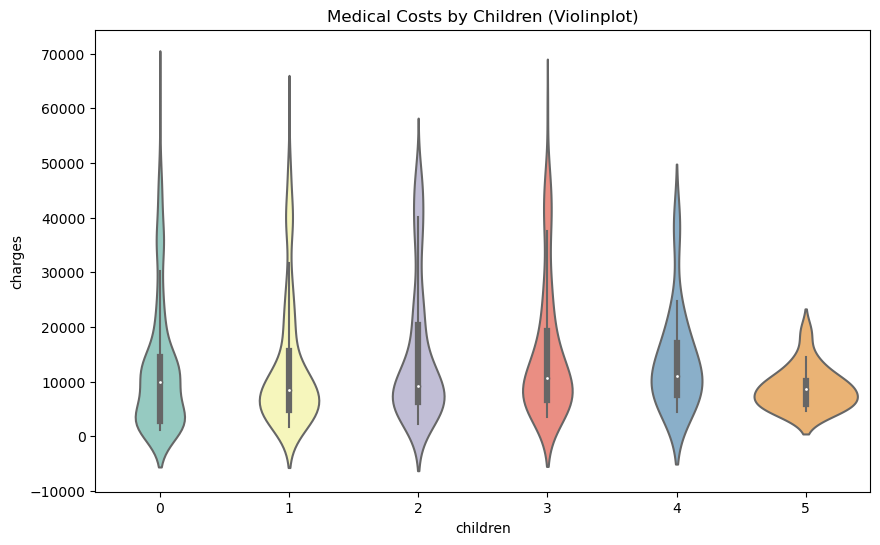

In [15]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='children', y='charges', data=df, palette="Set3")
plt.title('Medical Costs by Children (Violinplot)')
plt.show()

<Figure size 1000x600 with 0 Axes>

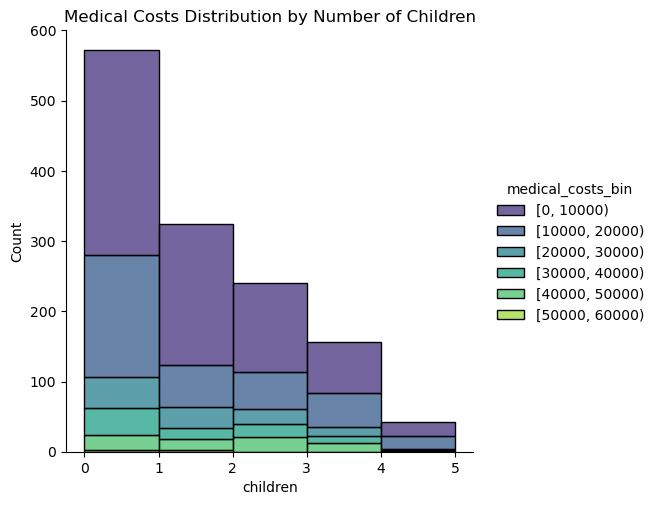

In [16]:
# Bin medical costs into chunks of 10,000
df['medical_costs_bin'] = pd.cut(df['charges'], bins=range(0, 70000, 10000), right=False)

# Plot using displot
plt.figure(figsize=(10
                    , 6))
sns.displot(data=df, x='children', hue='medical_costs_bin', multiple='stack', palette='viridis', binwidth=1)
plt.title('Medical Costs Distribution by Number of Children')
plt.show()

hard to derive any meaning between relationship between no. of children and medical cost

# Feature: Smoker

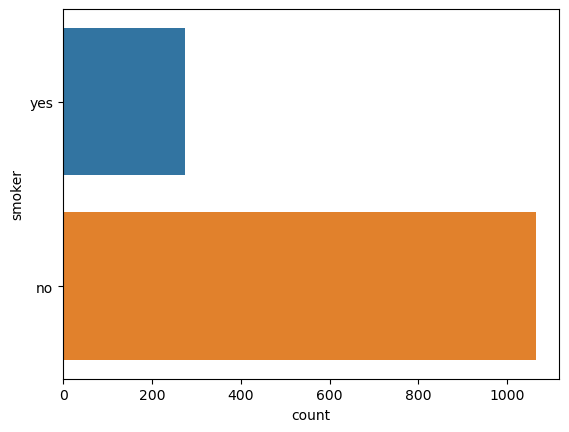

In [17]:
sns.countplot(y="smoker", data=df);

majority don't smoke

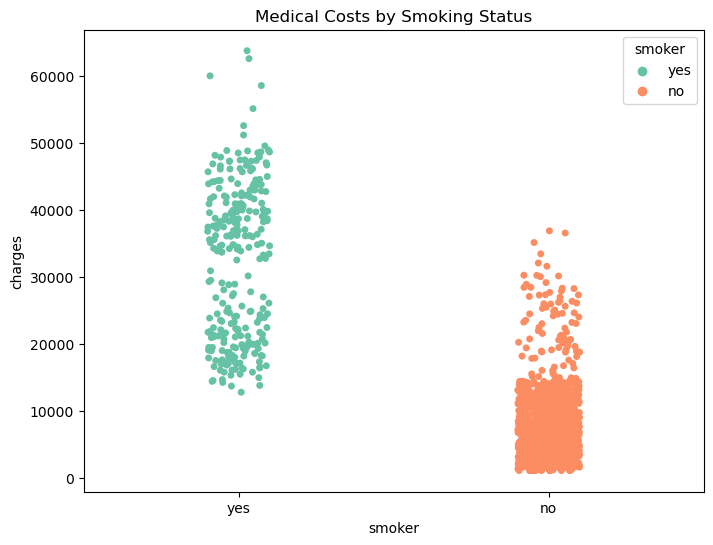

In [18]:
plt.figure(figsize=(8, 6))
sns.stripplot(x='smoker', y='charges', data=df, palette="Set2", hue="smoker", size=5, jitter=True)
plt.title('Medical Costs by Smoking Status')
plt.show()

This strip plot shows CLEARLY that smokers pay a massive amount more in medical costs!

<Axes: xlabel='region', ylabel='count'>

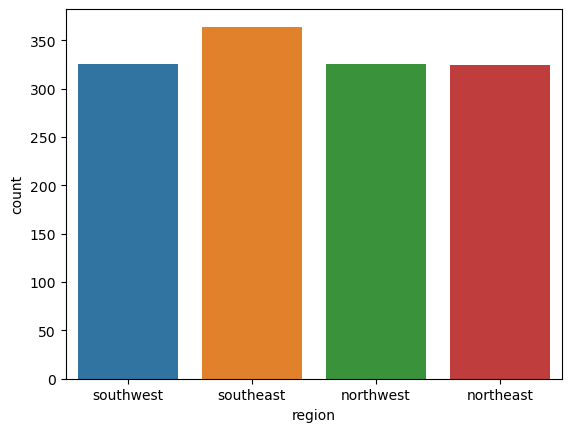

In [19]:
sns.countplot(x="region", data=df) # data shows there are four locations where people are living in this dataset,
# and a fairly even amount from all four courners of the country. 

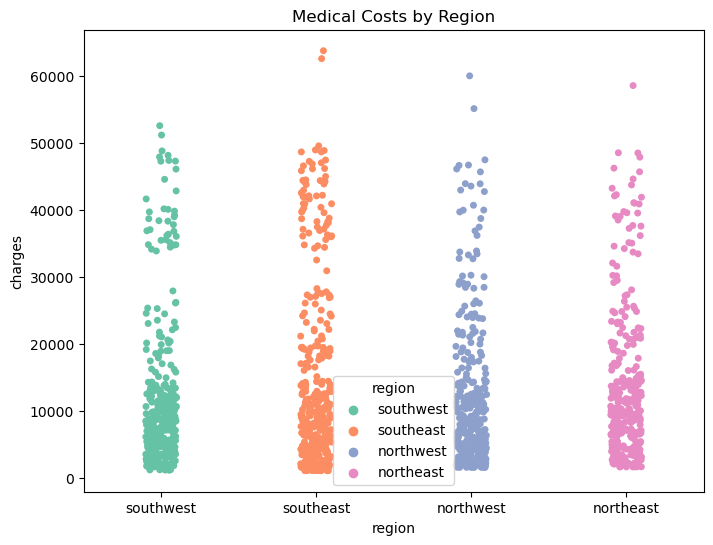

In [20]:
plt.figure(figsize=(8, 6))
sns.stripplot(x='region', y='charges', data=df, palette="Set2", hue="region", size=5, jitter=True)
plt.title('Medical Costs by Region')
plt.show()

looks fairly even, nothing clear taken from this!

# What our visualisations mean

Without properly exploring feature importance, I have dervied the most significant X column as "smoker", the "BMI" column also had implications in the sense people with bigger BMI clearly spent more on medical care

# Further pre-processing steps : one hot encoding and normalisation

In [21]:
df.dtypes

age                     int64
sex                    object
bmi                   float64
children                int64
smoker                 object
region                 object
charges               float64
medical_costs_bin    category
dtype: object

In [22]:
df

,age,sex,bmi,children,smoker,region,charges,medical_costs_bin
0,19,female,27.900,0,yes,southwest,16884.92400,"[10000, 20000)"
1,18,male,33.770,1,no,southeast,1725.55230,"[0, 10000)"
2,28,male,33.000,3,no,southeast,4449.46200,"[0, 10000)"
3,33,male,22.705,0,no,northwest,21984.47061,"[20000, 30000)"
4,32,male,28.880,0,no,northwest,3866.85520,"[0, 10000)"
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,"[10000, 20000)"
1334,18,female,31.920,0,no,northeast,2205.98080,"[0, 10000)"
1335,18,female,36.850,0,no,southeast,1629.83350,"[0, 10000)"
1336,21,female,25.800,0,no,southwest,2007.94500,"[0, 10000)"


In [23]:
df.drop("medical_costs_bin", axis=1, inplace=True) # when we created graph near top of project, we created bins
# but forgot it was actually added to DF, so I've now dropped it!

In [24]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


# Further pre-processing steps : one hot encoding

-sex

-smoker

-region

In [25]:
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)

# Display the resulting DataFrame
print(df_encoded)

      age     bmi  children      charges  sex_male  smoker_yes  \
0      19  27.900         0  16884.92400         0           1   
1      18  33.770         1   1725.55230         1           0   
2      28  33.000         3   4449.46200         1           0   
3      33  22.705         0  21984.47061         1           0   
4      32  28.880         0   3866.85520         1           0   
...   ...     ...       ...          ...       ...         ...   
1333   50  30.970         3  10600.54830         1           0   
1334   18  31.920         0   2205.98080         0           0   
1335   18  36.850         0   1629.83350         0           0   
1336   21  25.800         0   2007.94500         0           0   
1337   61  29.070         0  29141.36030         0           1   

      region_northwest  region_southeast  region_southwest  
0                    0                 0                 1  
1                    0                 1                 0  
2                    0  

In [26]:
df2 = df_encoded

In [27]:
df2

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,1,0,1,0,0
1334,18,31.920,0,2205.98080,0,0,0,0,0
1335,18,36.850,0,1629.83350,0,0,0,1,0
1336,21,25.800,0,2007.94500,0,0,0,0,1


# Normalise numeric columns: age and BMI

In [28]:
numerical_features = ['age', 'bmi']
features_to_scale = df2[numerical_features]

# Use StandardScaler to normalize the features
scaler = StandardScaler()
df2[numerical_features] = scaler.fit_transform(features_to_scale)

# Display the resulting DataFrame
print(df2)

           age       bmi  children      charges  sex_male  smoker_yes  \
0    -1.438764 -0.453320         0  16884.92400         0           1   
1    -1.509965  0.509621         1   1725.55230         1           0   
2    -0.797954  0.383307         3   4449.46200         1           0   
3    -0.441948 -1.305531         0  21984.47061         1           0   
4    -0.513149 -0.292556         0   3866.85520         1           0   
...        ...       ...       ...          ...       ...         ...   
1333  0.768473  0.050297         3  10600.54830         1           0   
1334 -1.509965  0.206139         0   2205.98080         0           0   
1335 -1.509965  1.014878         0   1629.83350         0           0   
1336 -1.296362 -0.797813         0   2007.94500         0           0   
1337  1.551686 -0.261388         0  29141.36030         0           1   

      region_northwest  region_southeast  region_southwest  
0                    0                 0                 1  
1

# Split data into X and y

In [29]:
X = df2.drop("charges", axis=1)
y = df2["charges"]

In [30]:
X.shape, y.shape

((1338, 8), (1338,))

# Split into test and train


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [32]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1070, 8), (268, 8), (1070,), (268,))

# Building first model : The function in cell below will be reused for every model

`from sklearn.model_selection import cross_val_predict` we imported this at top of project to help predict
`from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score` we also imported re

In [33]:
def fit_ml_algo(algo, X_train, y_train, cv):
    
    model = algo.fit(X_train, y_train)
    
    train_pred = model.predict(X_train) # in regression problems we predict on X_train
    
    # NOTE: the y_pred in the three lines of code below NEEDS to come before the prediction in order, like so...
    mae = round(mean_absolute_error(y_train, train_pred), 2) # comparing prediction to actual value, rounded to 2dp
    mse = round(mean_squared_error(y_train, train_pred), 2) # comparing prediction to actual value for mse
    r2 = round(r2_score(y_train, train_pred), 2) # comparing prediction to actual value for r2 score
    
    # cross-validated prediction 
    train_pred_cv = cross_val_predict(algo, # remember cross_val_predict is code from sklearn library 
                                      X_train,
                                      y_train,
                                      cv=cv,
                                      n_jobs = -1) # -1 allows parallel CPU usage, which can help performance
    
    # cross-validated regression metrics
    mae_cv = round(mean_absolute_error(y_train, train_pred_cv), 2)
    mse_cv = round(mean_squared_error(y_train, train_pred_cv), 2)
    r2_cv = round(r2_score(y_train, train_pred_cv), 2)
    
    return train_pred, mae, mse, r2, train_pred_cv, mae_cv, mse_cv, r2_cv

# Linear Regression

In [34]:
# Linear Regression
train_pred_lr, mae_lr, mse_lr, r2_lr, train_pred_cv_lr, mae_cv_lr, mse_cv_lr, r2_cv_lr = fit_ml_algo(LinearRegression(),
                                                                                                     X_train,
                                                                                                     y_train,
                                                                                                     10) # CV 10 folds

print(f"MAE: {mae_lr}")
print(f"MSE: {mse_lr}")
print(f"R-squared: {r2_lr}")
print(f"MAE CV 10-Fold: {mae_cv_lr}")
print(f"MSE CV 10-Fold: {mse_cv_lr}")
print(f"R-squared CV 10-Fold: {r2_cv_lr}")

MAE: 4164.0
MSE: 36811386.49
R-squared: 0.75
MAE CV 10-Fold: 4202.0
MSE CV 10-Fold: 37619874.92
R-squared CV 10-Fold: 0.74


# Other models we'll be building:


- RandomForestRegressor
- GradientBoostingRegressor
- SVR
- KNeighborsRegressor
- XGBRegressor
- GaussianProcessRegressor
- BaggingRegressor
- BayesianRidge

We already built Linear Regression model above to show the function we created in action ^

# RandomForestRegressor

**NOTE: When having to change a lot of the endings of the variables for each model, use `find and replace` in edit drop down menu to change all the endings in a specific cell at once, without tampering with other cells you may have copied the code from!**

In [35]:
# Random Forest Regressor
train_pred_rf, mae_rf, mse_rf, r2_rf, train_pred_cv_rf, mae_cv_rf, mse_cv_rf, r2_cv_rf = fit_ml_algo(RandomForestRegressor(),
                                                                                                     X_train,
                                                                                                     y_train,
                                                                                                     10)

print(f"MAE: {mae_rf}")
print(f"MSE: {mse_rf}")
print(f"R-squared: {r2_rf}")
print(f"MAE CV 10-Fold: {mae_cv_rf}")
print(f"MSE CV 10-Fold: {mse_cv_rf}")
print(f"R-squared CV 10-Fold: {r2_cv_rf}")

MAE: 1029.42
MSE: 3585968.65
R-squared: 0.98
MAE CV 10-Fold: 2777.58
MSE CV 10-Fold: 24762147.88
R-squared CV 10-Fold: 0.83


# GradientBoostingRegressor

In [36]:
# Gradient Boosting Regressor
train_pred_gb, mae_gb, mse_gb, r2_gb, train_pred_cv_gb, mae_cv_gb, mse_cv_gb, r2_cv_gb = fit_ml_algo(GradientBoostingRegressor(),
                                                                                                     X_train,
                                                                                                     y_train,
                                                                                                     10)

print(f"MAE: {mae_gb}")
print(f"MSE: {mse_gb}")
print(f"R-squared: {r2_gb}")
print(f"MAE CV 10-Fold: {mae_cv_gb}")
print(f"MSE CV 10-Fold: {mse_cv_gb}")
print(f"R-squared CV 10-Fold: {r2_cv_gb}")

MAE: 2053.67
MSE: 14287240.83
R-squared: 0.9
MAE CV 10-Fold: 2559.75
MSE CV 10-Fold: 21861548.19
R-squared CV 10-Fold: 0.85


# SVR

In [37]:
# SVR
train_pred_svr, mae_svr, mse_svr, r2_svr, train_pred_cv_svr, mae_cv_svr, mse_cv_svr, r2_cv_svr = fit_ml_algo(SVR(),
                                                                                                     X_train,
                                                                                                     y_train,
                                                                                                     10)

print(f"MAE: {mae_svr}")
print(f"MSE: {mse_svr}")
print(f"R-squared: {r2_svr}")
print(f"MAE CV 10-Fold: {mae_cv_svr}")
print(f"MSE CV 10-Fold: {mse_cv_svr}")
print(f"R-squared CV 10-Fold: {r2_cv_svr}")

MAE: 8269.3
MSE: 160267339.02
R-squared: -0.1
MAE CV 10-Fold: 8282.18
MSE CV 10-Fold: 160443128.58
R-squared CV 10-Fold: -0.1


# KNeighborsRegressor

In [38]:
# KNN
train_pred_knn, mae_knn, mse_knn, r2_knn, train_pred_cv_knn, mae_cv_knn, mse_cv_knn, r2_cv_knn = fit_ml_algo(KNeighborsRegressor(),
                                                                                                     X_train,
                                                                                                     y_train,
                                                                                                     10)

print(f"MAE: {mae_knn}")
print(f"MSE: {mse_knn}")
print(f"R-squared: {r2_knn}")
print(f"MAE CV 10-Fold: {mae_cv_knn}")
print(f"MSE CV 10-Fold: {mse_cv_knn}")
print(f"R-squared CV 10-Fold: {r2_cv_knn}")

MAE: 3185.17
MSE: 29978517.87
R-squared: 0.79
MAE CV 10-Fold: 4240.21
MSE CV 10-Fold: 49656089.13
R-squared CV 10-Fold: 0.66


# XGBRegressor

In [39]:
# XGBRegressor
train_pred_xgb, mae_xgb, mse_xgb, r2_xgb, train_pred_cv_xgb, mae_cv_xgb, mse_cv_xgb, r2_cv_xgb = fit_ml_algo(XGBRegressor(),
                                                                                                     X_train,
                                                                                                     y_train,
                                                                                                     10)

print(f"MAE: {mae_xgb}")
print(f"MSE: {mse_xgb}")
print(f"R-squared: {r2_xgb}")
print(f"MAE CV 10-Fold: {mae_cv_xgb}")
print(f"MSE CV 10-Fold: {mse_cv_xgb}")
print(f"R-squared CV 10-Fold: {r2_cv_xgb}")

MAE: 474.74
MSE: 761531.82
R-squared: 0.99
MAE CV 10-Fold: 3123.46
MSE CV 10-Fold: 28490763.77
R-squared CV 10-Fold: 0.8


# GaussianProcessRegressor

In [40]:
# GaussianProcessRegressor
train_pred_gpr, mae_gpr, mse_gpr, r2_gpr, train_pred_cv_gpr, mae_cv_gpr, mse_cv_gpr, r2_cv_gpr = fit_ml_algo(GaussianProcessRegressor(),
                                                                                                     X_train,
                                                                                                     y_train,
                                                                                                     10)

print(f"MAE: {mae_gpr}")
print(f"MSE: {mse_gpr}")
print(f"R-squared: {r2_gpr}")
print(f"MAE CV 10-Fold: {mae_cv_gpr}")
print(f"MSE CV 10-Fold: {mse_cv_gpr}")
print(f"R-squared CV 10-Fold: {r2_cv_gpr}")

MAE: 38.8
MSE: 253831.55
R-squared: 1.0
MAE CV 10-Fold: 192852.25
MSE CV 10-Fold: 394597853225.24
R-squared CV 10-Fold: -2708.86


# BaggingRegressor

In [41]:
# BaggingRegressor
train_pred_br, mae_br, mse_br, r2_br, train_pred_cv_br, mae_cv_br, mse_cv_br, r2_cv_br = fit_ml_algo(BaggingRegressor(),
                                                                                                     X_train,
                                                                                                     y_train,
                                                                                                     10)

print(f"MAE: {mae_br}")
print(f"MSE: {mse_br}")
print(f"R-squared: {r2_br}")
print(f"MAE CV 10-Fold: {mae_cv_br}")
print(f"MSE CV 10-Fold: {mse_cv_br}")
print(f"R-squared CV 10-Fold: {r2_cv_br}")

MAE: 1139.88
MSE: 4765951.4
R-squared: 0.97
MAE CV 10-Fold: 2786.77
MSE CV 10-Fold: 25364159.44
R-squared CV 10-Fold: 0.83


# BayesianRidge 

In [42]:
# BayesianRidge
train_pred_bayr, mae_bayr, mse_bayr, r2_bayr, train_pred_cv_bayr, mae_cv_bayr, mse_cv_bayr, r2_cv_bayr = fit_ml_algo(BayesianRidge(),
                                                                                                     X_train,
                                                                                                     y_train,
                                                                                                     10)

print(f"MAE: {mae_bayr}")
print(f"MSE: {mse_bayr}")
print(f"R-squared: {r2_bayr}")
print(f"MAE CV 10-Fold: {mae_cv_bayr}")
print(f"MSE CV 10-Fold: {mse_cv_bayr}")
print(f"R-squared CV 10-Fold: {r2_cv_bayr}")

MAE: 4169.18
MSE: 36812198.2
R-squared: 0.75
MAE CV 10-Fold: 4207.66
MSE CV 10-Fold: 37620656.87
R-squared CV 10-Fold: 0.74


# Evaluating model performance

Let's remind ourselves of all the models we trained on...

- Linear Regression 

- RandomForestRegressor

- GradientBoostingRegressor

- SVR

- KNeighborsRegressor

- XGBRegressor

- GaussianProcessRegressor

- BaggingRegressor

- BayesianRidge


**GradientBoostingRegressor: Due to unusual results in R2 score, we will leave this model out of further training**

In [43]:
evaluation_results = {
    'LinearRegression': [mae_lr, mse_lr, r2_lr],
    'RandomForestRegressor': [mae_rf, mse_rf, r2_rf],
    'GradientBoostingRegressor': [mae_gb, mse_gb, r2_gb],
    'SVR': [mae_svr, mse_svr, r2_svr],
    'KNeighborsRegressor': [mae_knn, mse_knn, r2_knn],
    'XGBRegressor': [mae_xgb, mse_xgb, r2_xgb],
    'BaggingRegressor': [mae_br, mse_br, r2_br],
    'BayesianRidge': [mae_br, mse_br, r2_br],
}

cv_results = {
    'LinearRegression': [mae_cv_lr, mse_cv_lr, r2_cv_lr],
    'RandomForestRegressor': [mae_cv_rf, mse_cv_rf, r2_cv_rf],
    'GradientBoostingRegressor': [mae_cv_gb, mse_cv_gb, r2_cv_gb],
    'SVR': [mae_cv_svr, mse_cv_svr, r2_cv_svr],
    'KNeighborsRegressor': [mae_cv_knn, mse_cv_knn, r2_cv_knn],
    'XGBRegressor': [mae_cv_xgb, mse_cv_xgb, r2_cv_xgb],
    'BaggingRegressor': [mae_cv_br, mse_cv_br, r2_cv_br],
    'BayesianRidge': [mae_cv_br, mse_cv_br, r2_cv_br],
}

# Create DataFrames with transposed axes
df_evaluation = pd.DataFrame(evaluation_results, index=['MAE', 'MSE', 'R2']).transpose() # we transposed both DF's,
#because originally the metrics we're all the rows. But in this format it's easier to visualise and create code
# for seaborn visuals. 
df_cv_results = pd.DataFrame(cv_results, index=['CV_MAE', 'CV_MSE', 'CV_R2']).transpose()

In [44]:
df_evaluation

,MAE,MSE,R2
LinearRegression,4164.00,3.681139e+07,0.75
RandomForestRegressor,1029.42,3.585969e+06,0.98
GradientBoostingRegressor,2053.67,1.428724e+07,0.90
SVR,8269.30,1.602673e+08,-0.10
KNeighborsRegressor,3185.17,2.997852e+07,0.79
XGBRegressor,474.74,7.615318e+05,0.99
BaggingRegressor,1139.88,4.765951e+06,0.97
BayesianRidge,1139.88,4.765951e+06,0.97


In [45]:
df_cv_results

,CV_MAE,CV_MSE,CV_R2
LinearRegression,4202.00,3.761987e+07,0.74
RandomForestRegressor,2777.58,2.476215e+07,0.83
GradientBoostingRegressor,2559.75,2.186155e+07,0.85
SVR,8282.18,1.604431e+08,-0.10
KNeighborsRegressor,4240.21,4.965609e+07,0.66
XGBRegressor,3123.46,2.849076e+07,0.80
BaggingRegressor,2786.77,2.536416e+07,0.83
BayesianRidge,2786.77,2.536416e+07,0.83


### Evaluation visuals: create bar plot : MAE

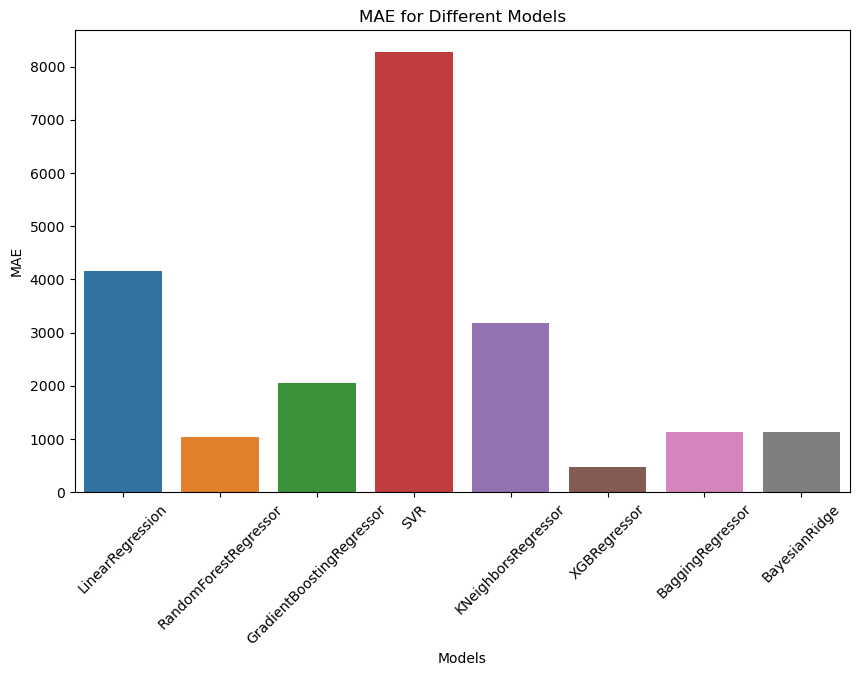

In [46]:
# Create a barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=df_evaluation.index, y=df_evaluation["MAE"])
plt.xlabel("Models")
plt.ylabel("MAE")
plt.title("MAE for Different Models")
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

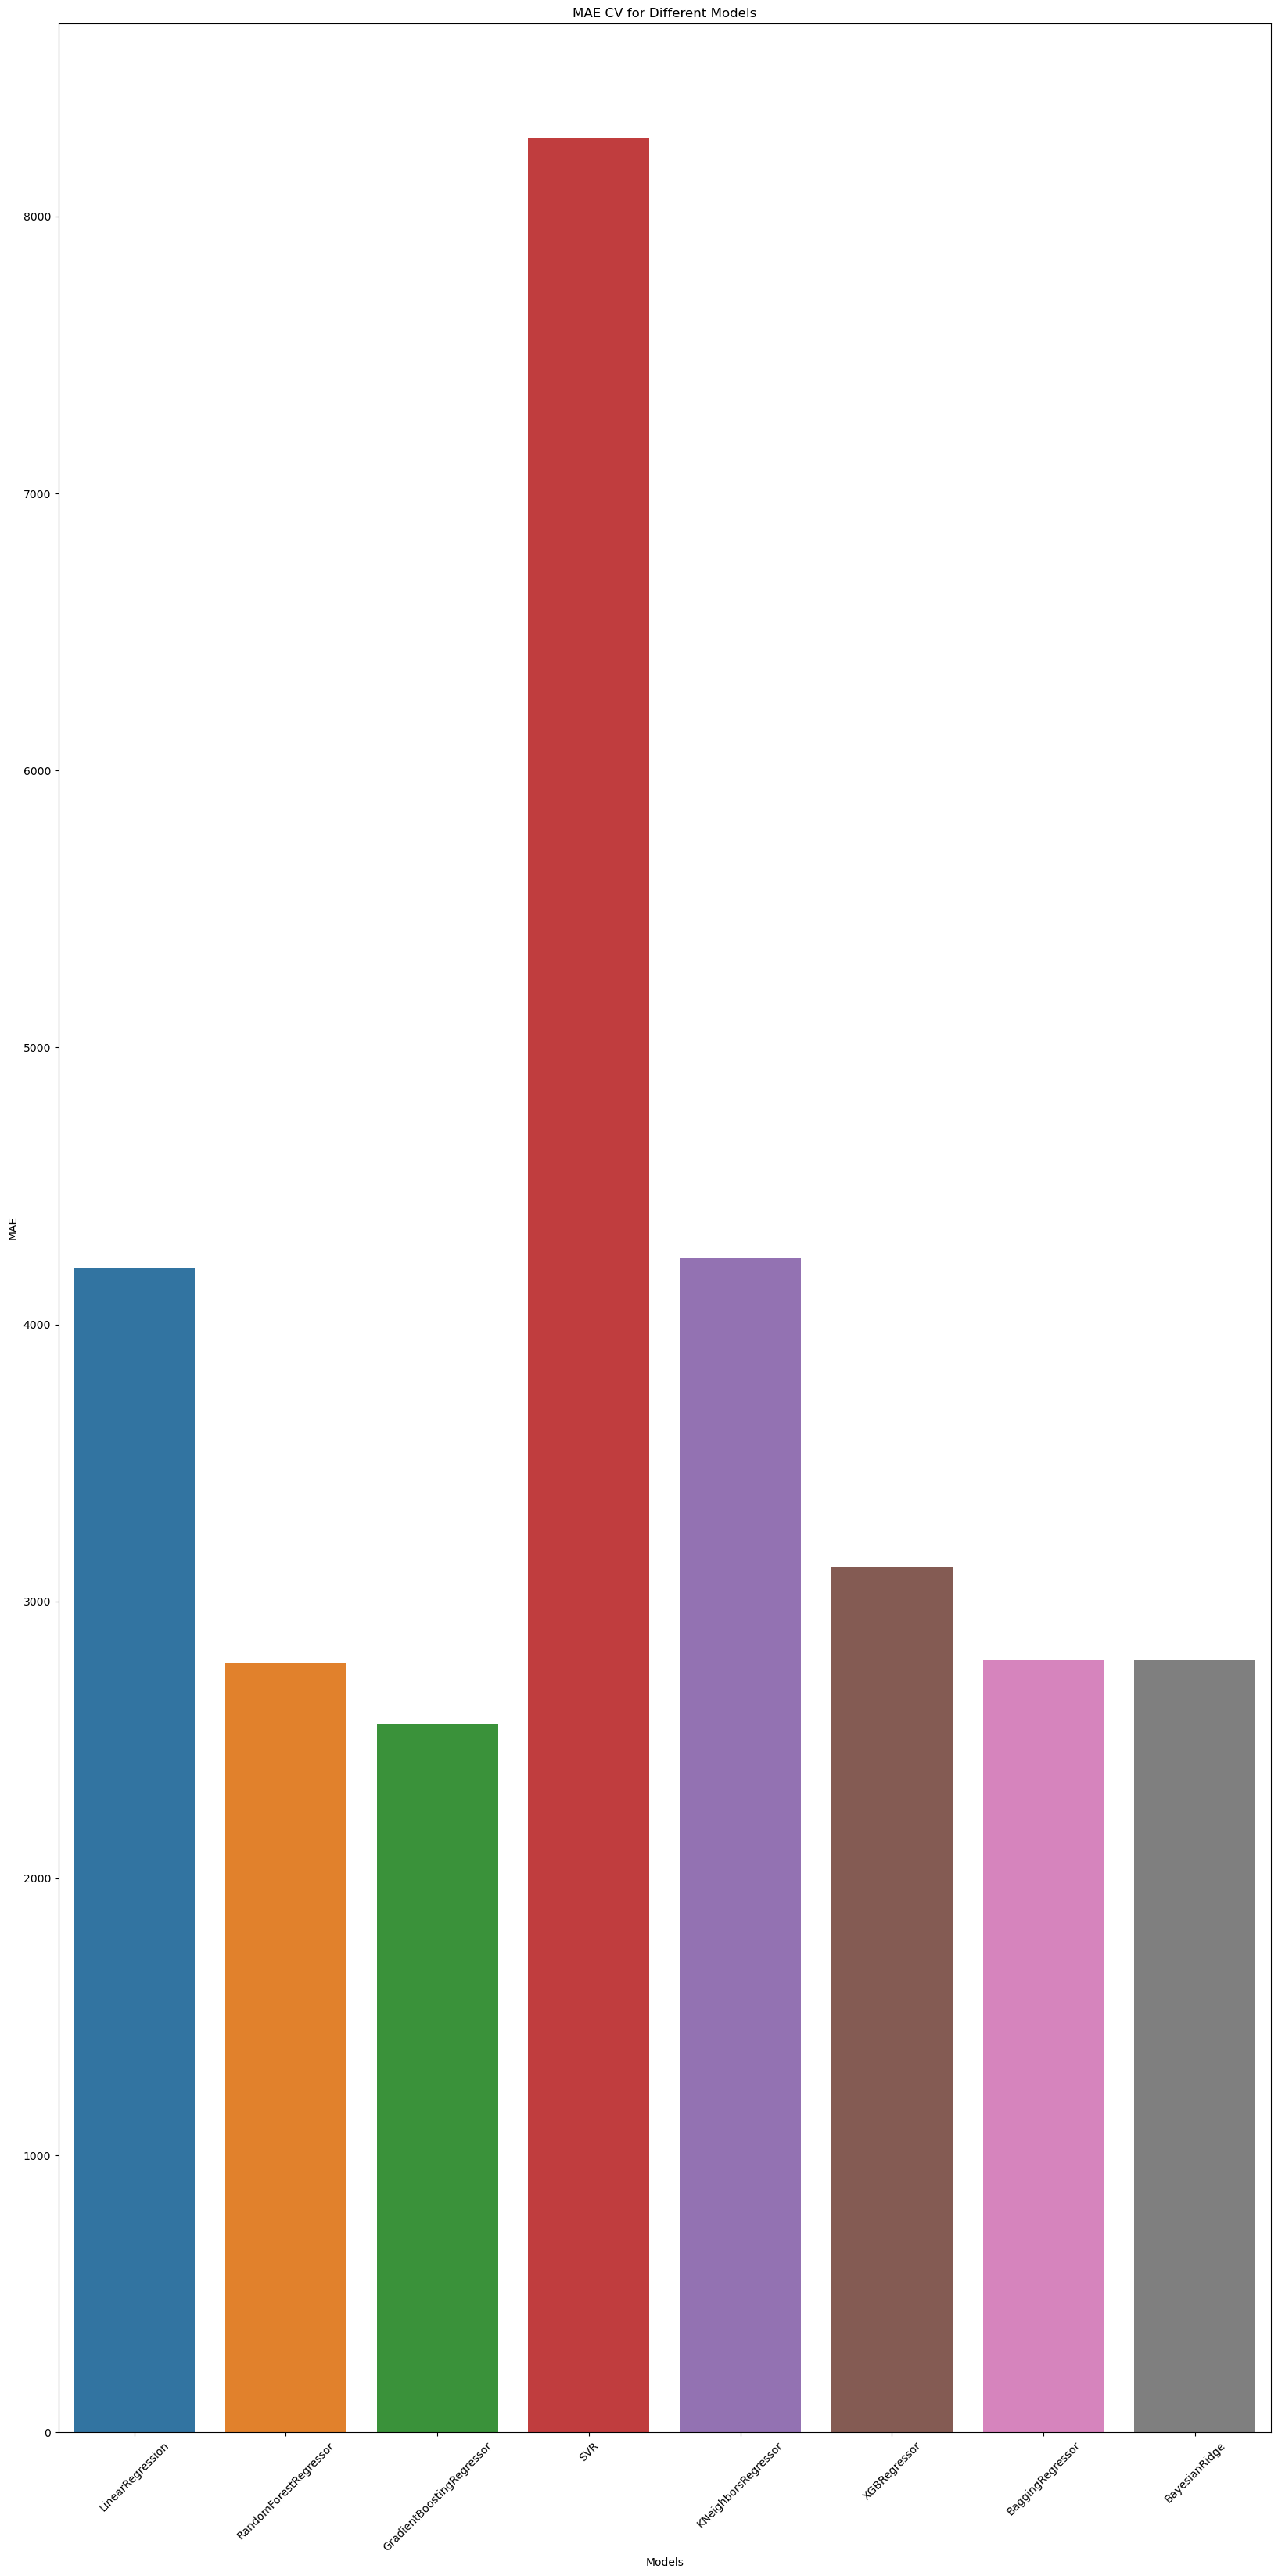

In [47]:
# Create a barplot for cross-validation 
plt.figure(figsize=(20, 40))
sns.barplot(x=df_cv_results.index, y=df_cv_results["CV_MAE"])
plt.xlabel("Models")
plt.ylabel("MAE")
plt.title("MAE CV for Different Models")
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

### Evaluation visuals: create bar plot : R2

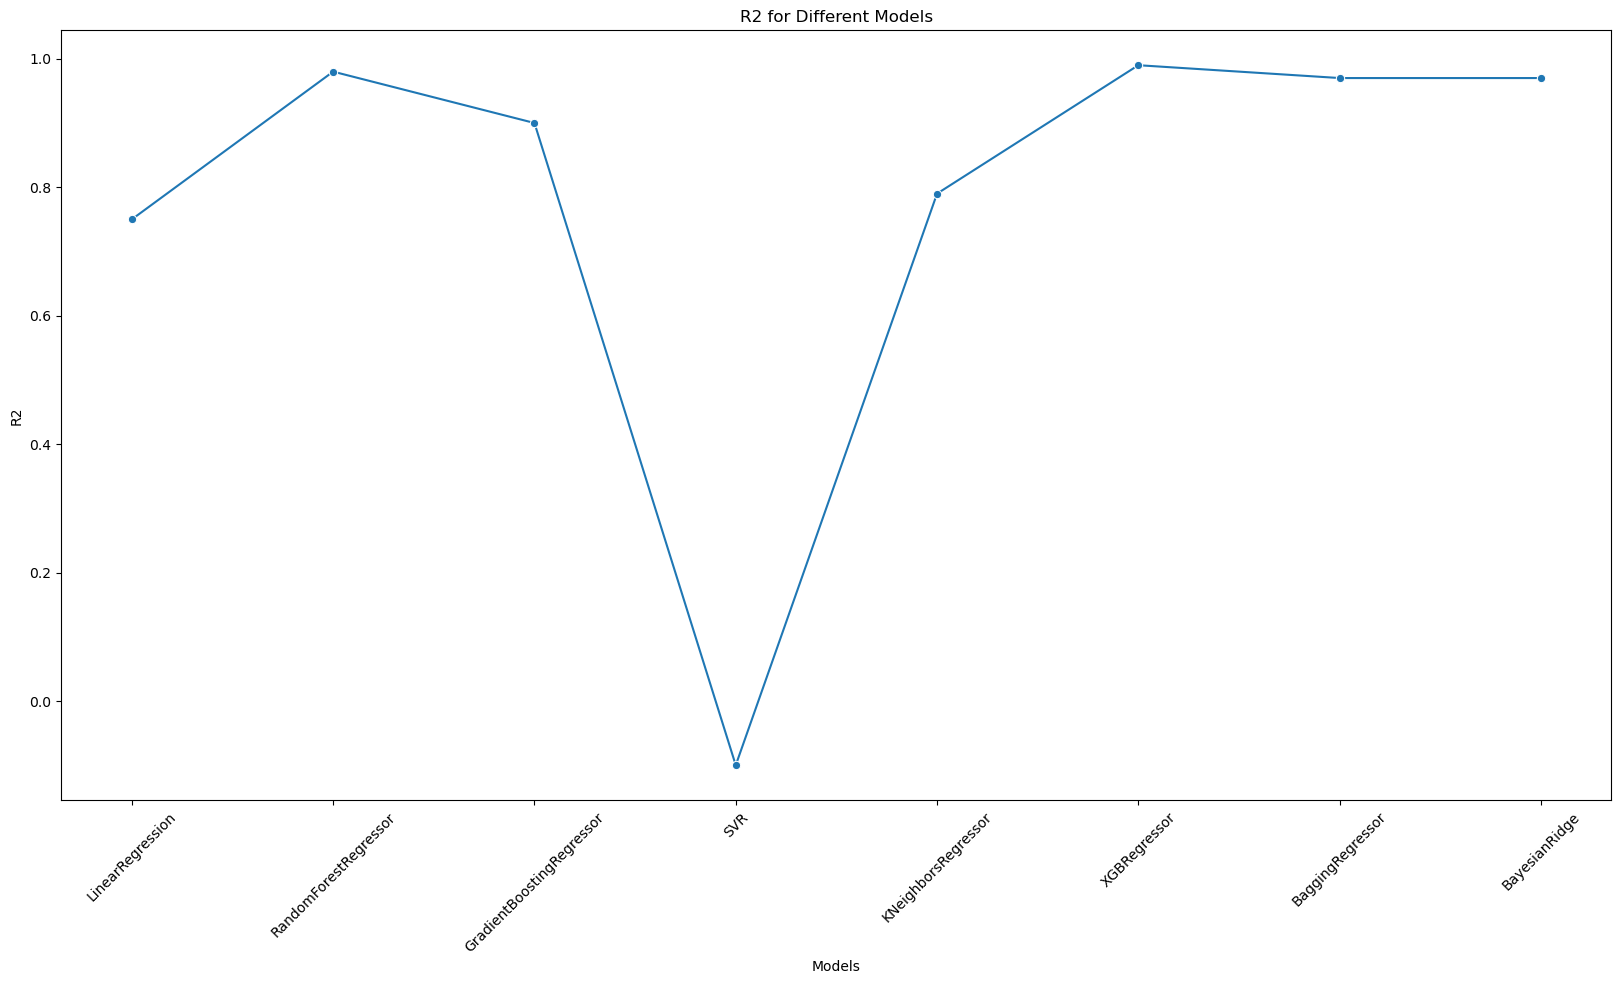

In [48]:
plt.figure(figsize=(20, 10))
sns.lineplot(x=df_evaluation.index, y=df_evaluation["R2"], marker='o')
plt.xlabel("Models")
plt.ylabel("R2")
plt.title("R2 for Different Models")
plt.xticks(rotation=45)
plt.show()

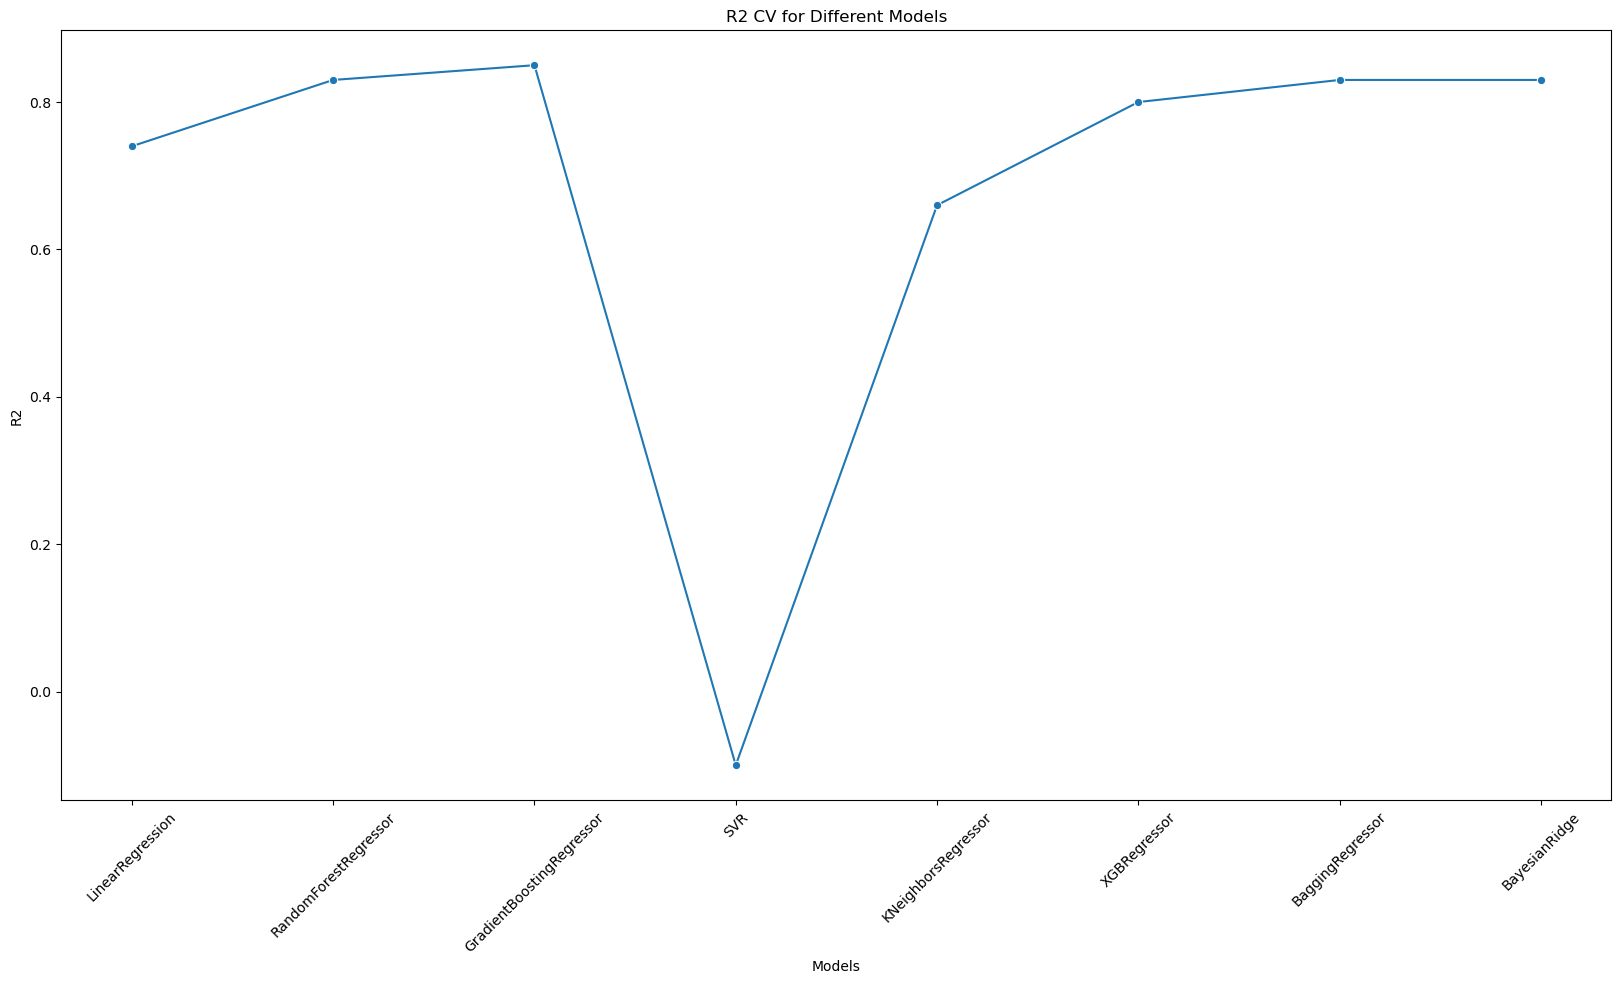

In [49]:
plt.figure(figsize=(20, 10))
sns.lineplot(x=df_cv_results.index, y=df_cv_results["CV_R2"], marker='o')
plt.xlabel("Models")
plt.ylabel("R2")
plt.title("R2 CV for Different Models")
plt.xticks(rotation=45)
plt.show()

### Evaluation visuals: create bar plot : MSE

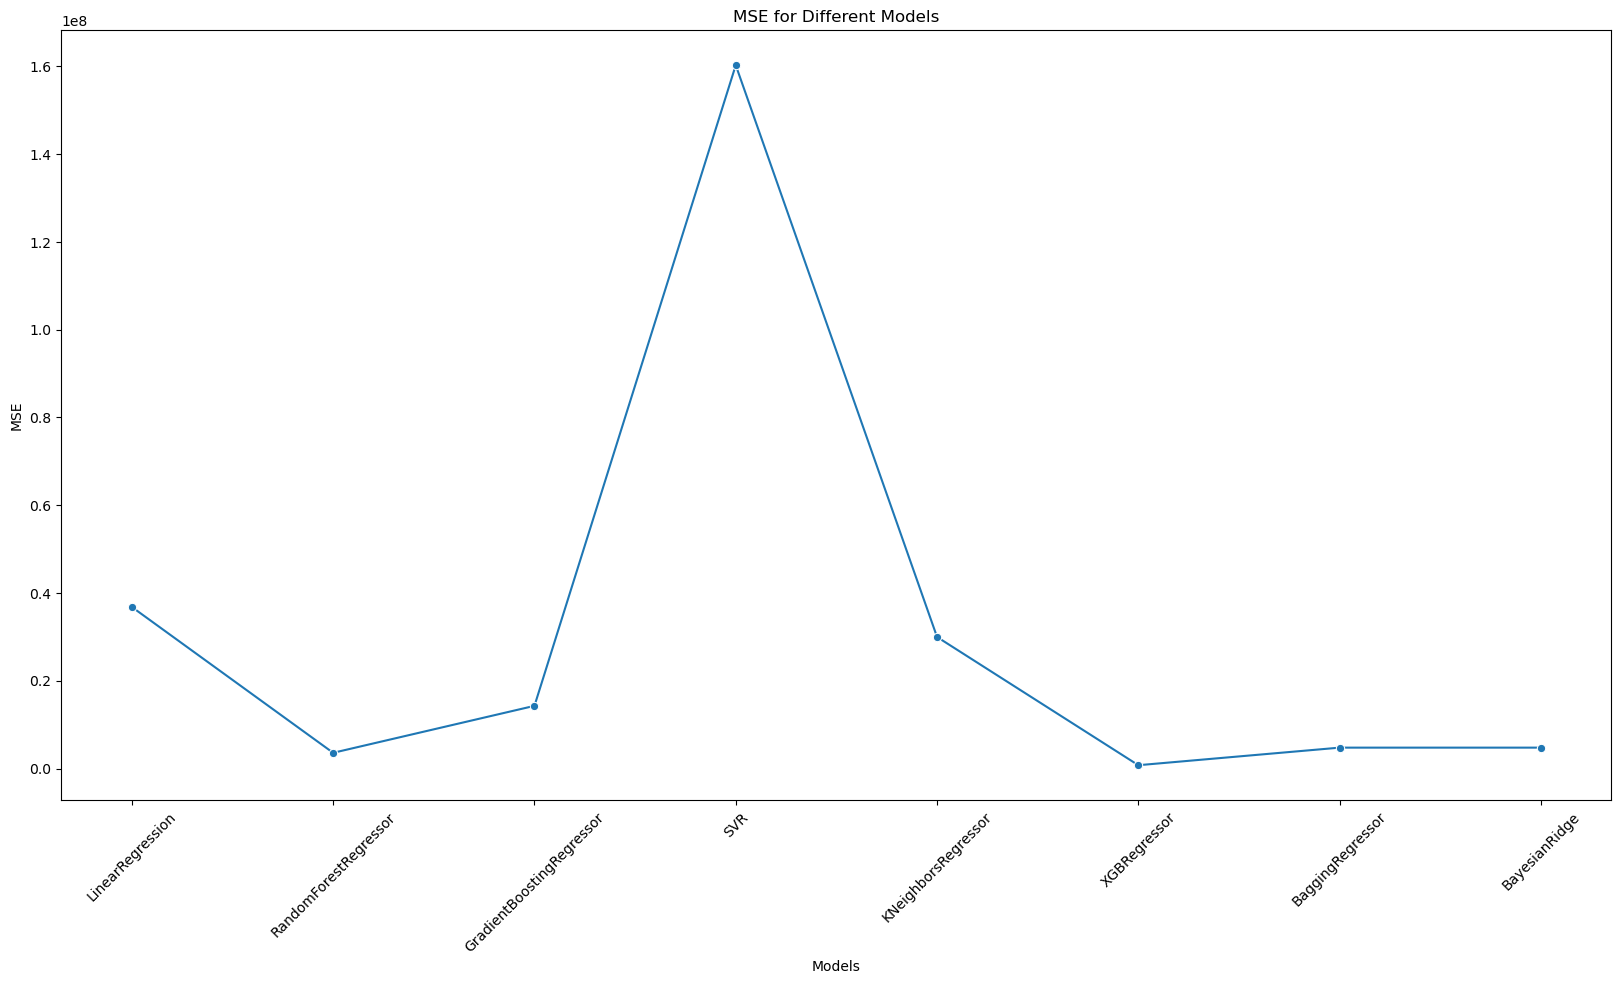

In [50]:
plt.figure(figsize=(20, 10))
sns.lineplot(x=df_evaluation.index, y=df_evaluation["MSE"], marker='o')
plt.xlabel("Models")
plt.ylabel("MSE")
plt.title("MSE for Different Models")
plt.xticks(rotation=45)
plt.show()

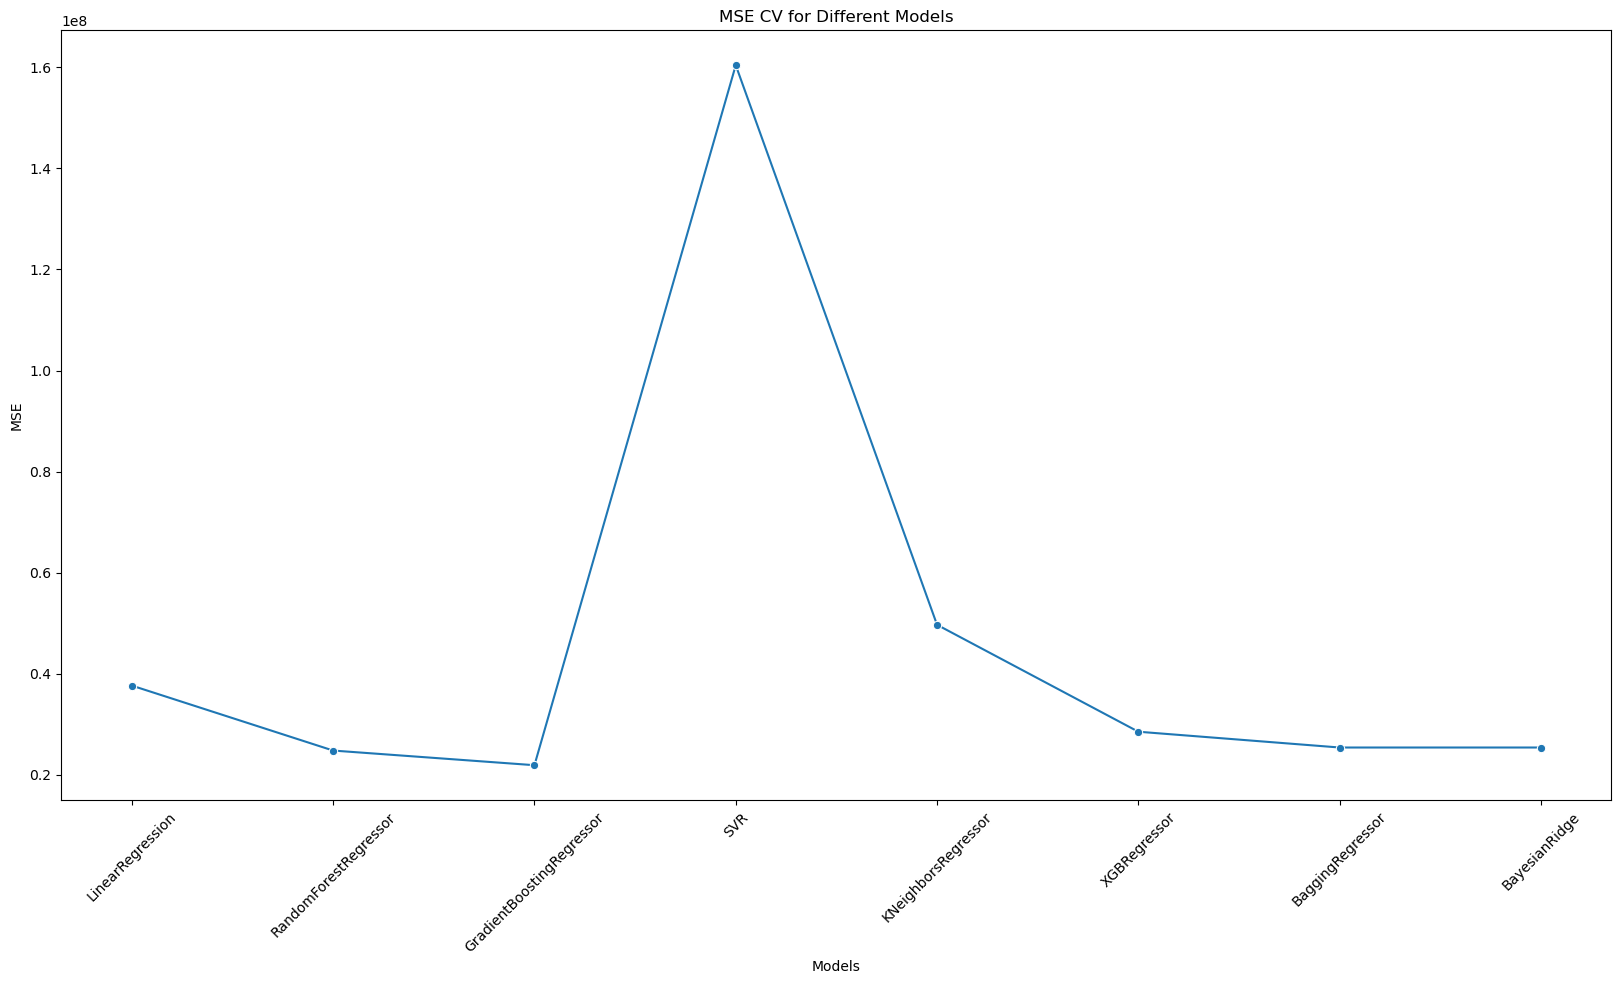

In [51]:
plt.figure(figsize=(20, 10))
sns.lineplot(x=df_cv_results.index, y=df_cv_results["CV_MSE"], marker='o')
plt.xlabel("Models")
plt.ylabel("MSE")
plt.title("MSE CV for Different Models")
plt.xticks(rotation=45)
plt.show()

# Findings:

## Across all our models, when I have assessed their performance, GradientBoostingRegeressor performed extremley well! In addition, because my main goal in the project was to work on MAE as a metric, I will also perform hyper-parameter tuning on RandomForestRegressor model

**GradientBoostingRegressor** We are aiming to beat **MAE CV 10-Fold: 2559.38**

**RandomForestRegressor**


In [52]:
# 

In [53]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint  # Import randint from scipy.stats

In [54]:
# Define the model
gbr_model = GradientBoostingRegressor()

# Define the hyperparameter distribution
param_dist = {
    'n_estimators': randint(10, 200),  # Adjust the range as needed
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 20),  # Adjust the range as needed
    'min_samples_leaf': randint(1, 10),  # Adjust the range as needed
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=gbr_model,
                                    param_distributions=param_dist,
                                    n_iter=10,  # Adjust the number of iterations
                                    cv=10,
                                    scoring='neg_mean_absolute_error',
                                    n_jobs=-1,
                                    random_state=42)  # Set a random seed for reproducibility

# Fit the model to the data
random_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 9, 'min_samples_split': 18, 'n_estimators': 68}
Best Score: -2875.487956720774


In [55]:
# Define the GradientBoostingRegressor
gbr_model = GradientBoostingRegressor()

# Define the hyperparameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 500),  # Adjust the range as needed
    'max_depth': [None, 5, 10, 15, 20, 30],  # Adjust the values as needed
    'min_samples_split': randint(2, 30),  # Adjust the range as needed
    'min_samples_leaf': randint(1, 20),  # Adjust the range as needed
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=gbr_model,
                                    param_distributions=param_dist,
                                    n_iter=20,  # Adjust the number of iterations
                                    cv=10,
                                    scoring='neg_mean_absolute_error',
                                    n_jobs=-1,
                                    random_state=42)  # Set a random seed for reproducibility

# Fit the model to the data
random_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 51}
Best Score: -2593.5525244297046


In [67]:
# Define the GradientBoostingRegressor
rf_model = RandomForestRegressor()

# Define the hyperparameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 500),  # Adjust the range as needed
    'max_depth': [None, 5, 10, 15, 20, 30],  # Adjust the values as needed
    'min_samples_split': randint(2, 30),  # Adjust the range as needed
    'min_samples_leaf': randint(1, 20),  # Adjust the range as needed
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=rf_model,
                                    param_distributions=param_dist,
                                    n_iter=20,  # Adjust the number of iterations
                                    cv=10,
                                    scoring='neg_mean_absolute_error',
                                    n_jobs=-1,
                                    random_state=42)  # Set a random seed for reproducibility

# Fit the model to the data
random_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)



Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 51}
Best Score: -2535.7197872101046


In [78]:
# Get the best model from random search
best_model = random_search.best_estimator_

# Save the best model to a file
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']

NOTE: We have saved best performing model...if we want to use it to compare our preds to actual y_test medical costs, remember we'll have to preprocess data in same way we preprocessed X_train. 

# Our Findings

## After exhaustive searching using both GridSearchCV and RandomizedSearchCV, we discovered that after some tweaking, RandomForestRegressor actually outperformed GradientBoostingRegressor, achieving a cross-validated MAE of **2525.29** with RandomizedSearchCV. 

When we consider the massive range of medical bills that people encounter, to get within around 2500 (dollars or pounds, or whatever currency the data is in, because the dataset hasn't given us this information), is a successful result. 

There is ways in which we could further improve the model, such as `feature engineering` , which means we create new columns to improve its performance. We can do this by collecting more data off of specialists, or deriving further meaning from current columns to engineer into new ones. 

We could also look at `feature importance` and from that get rid of less meaningful data to hone in on the most important features. I think we got a good inkling into this when we explored the data at start of project.

<Axes: xlabel='charges', ylabel='Count'>

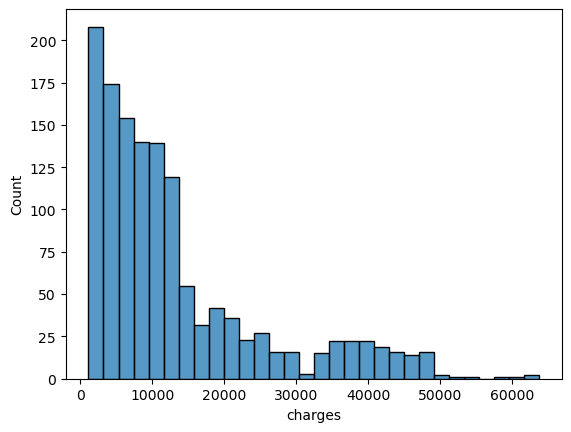

In [62]:
sns.histplot(df.charges)